- 目的：看一下检测到的异常点在原始数据中有哪些异常特征表现
- 顺便和正常值的一些指标做对比

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np


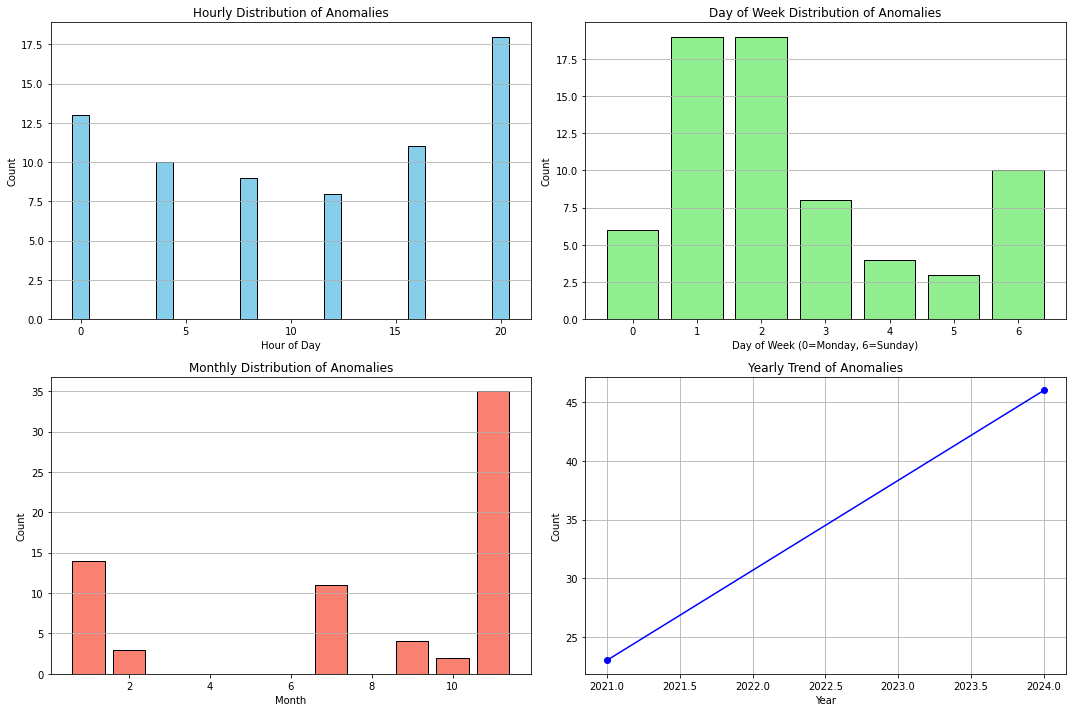

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open('experiment/Singapore_port/full_dataset_anomaly_timestamps.json', 'r') as file:
    data = json.load(file)
timestamps = pd.to_datetime(data['anomaly_timestamps'])

df = pd.DataFrame({
    "timestamp": timestamps,
    "hour": timestamps.hour,
    "day_of_week": timestamps.dayofweek, 
    "month": timestamps.month,
    "year": timestamps.year
})

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].bar(df['hour'].value_counts().sort_index().index,
               df['hour'].value_counts().sort_index().values, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Hourly Distribution of Anomalies')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(axis='y')

axes[0, 1].bar(df['day_of_week'].value_counts().sort_index().index,
               df['day_of_week'].value_counts().sort_index().values, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Day of Week Distribution of Anomalies')
axes[0, 1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(axis='y')

axes[1, 0].bar(df['month'].value_counts().sort_index().index,
               df['month'].value_counts().sort_index().values, color='salmon', edgecolor='black')
axes[1, 0].set_title('Monthly Distribution of Anomalies')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Count')
axes[1, 0].grid(axis='y')

axes[1, 1].plot(df['year'].value_counts().sort_index().index,
                df['year'].value_counts().sort_index().values, marker='o', color='blue')
axes[1, 1].set_title('Yearly Trend of Anomalies')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid()

plt.tight_layout()




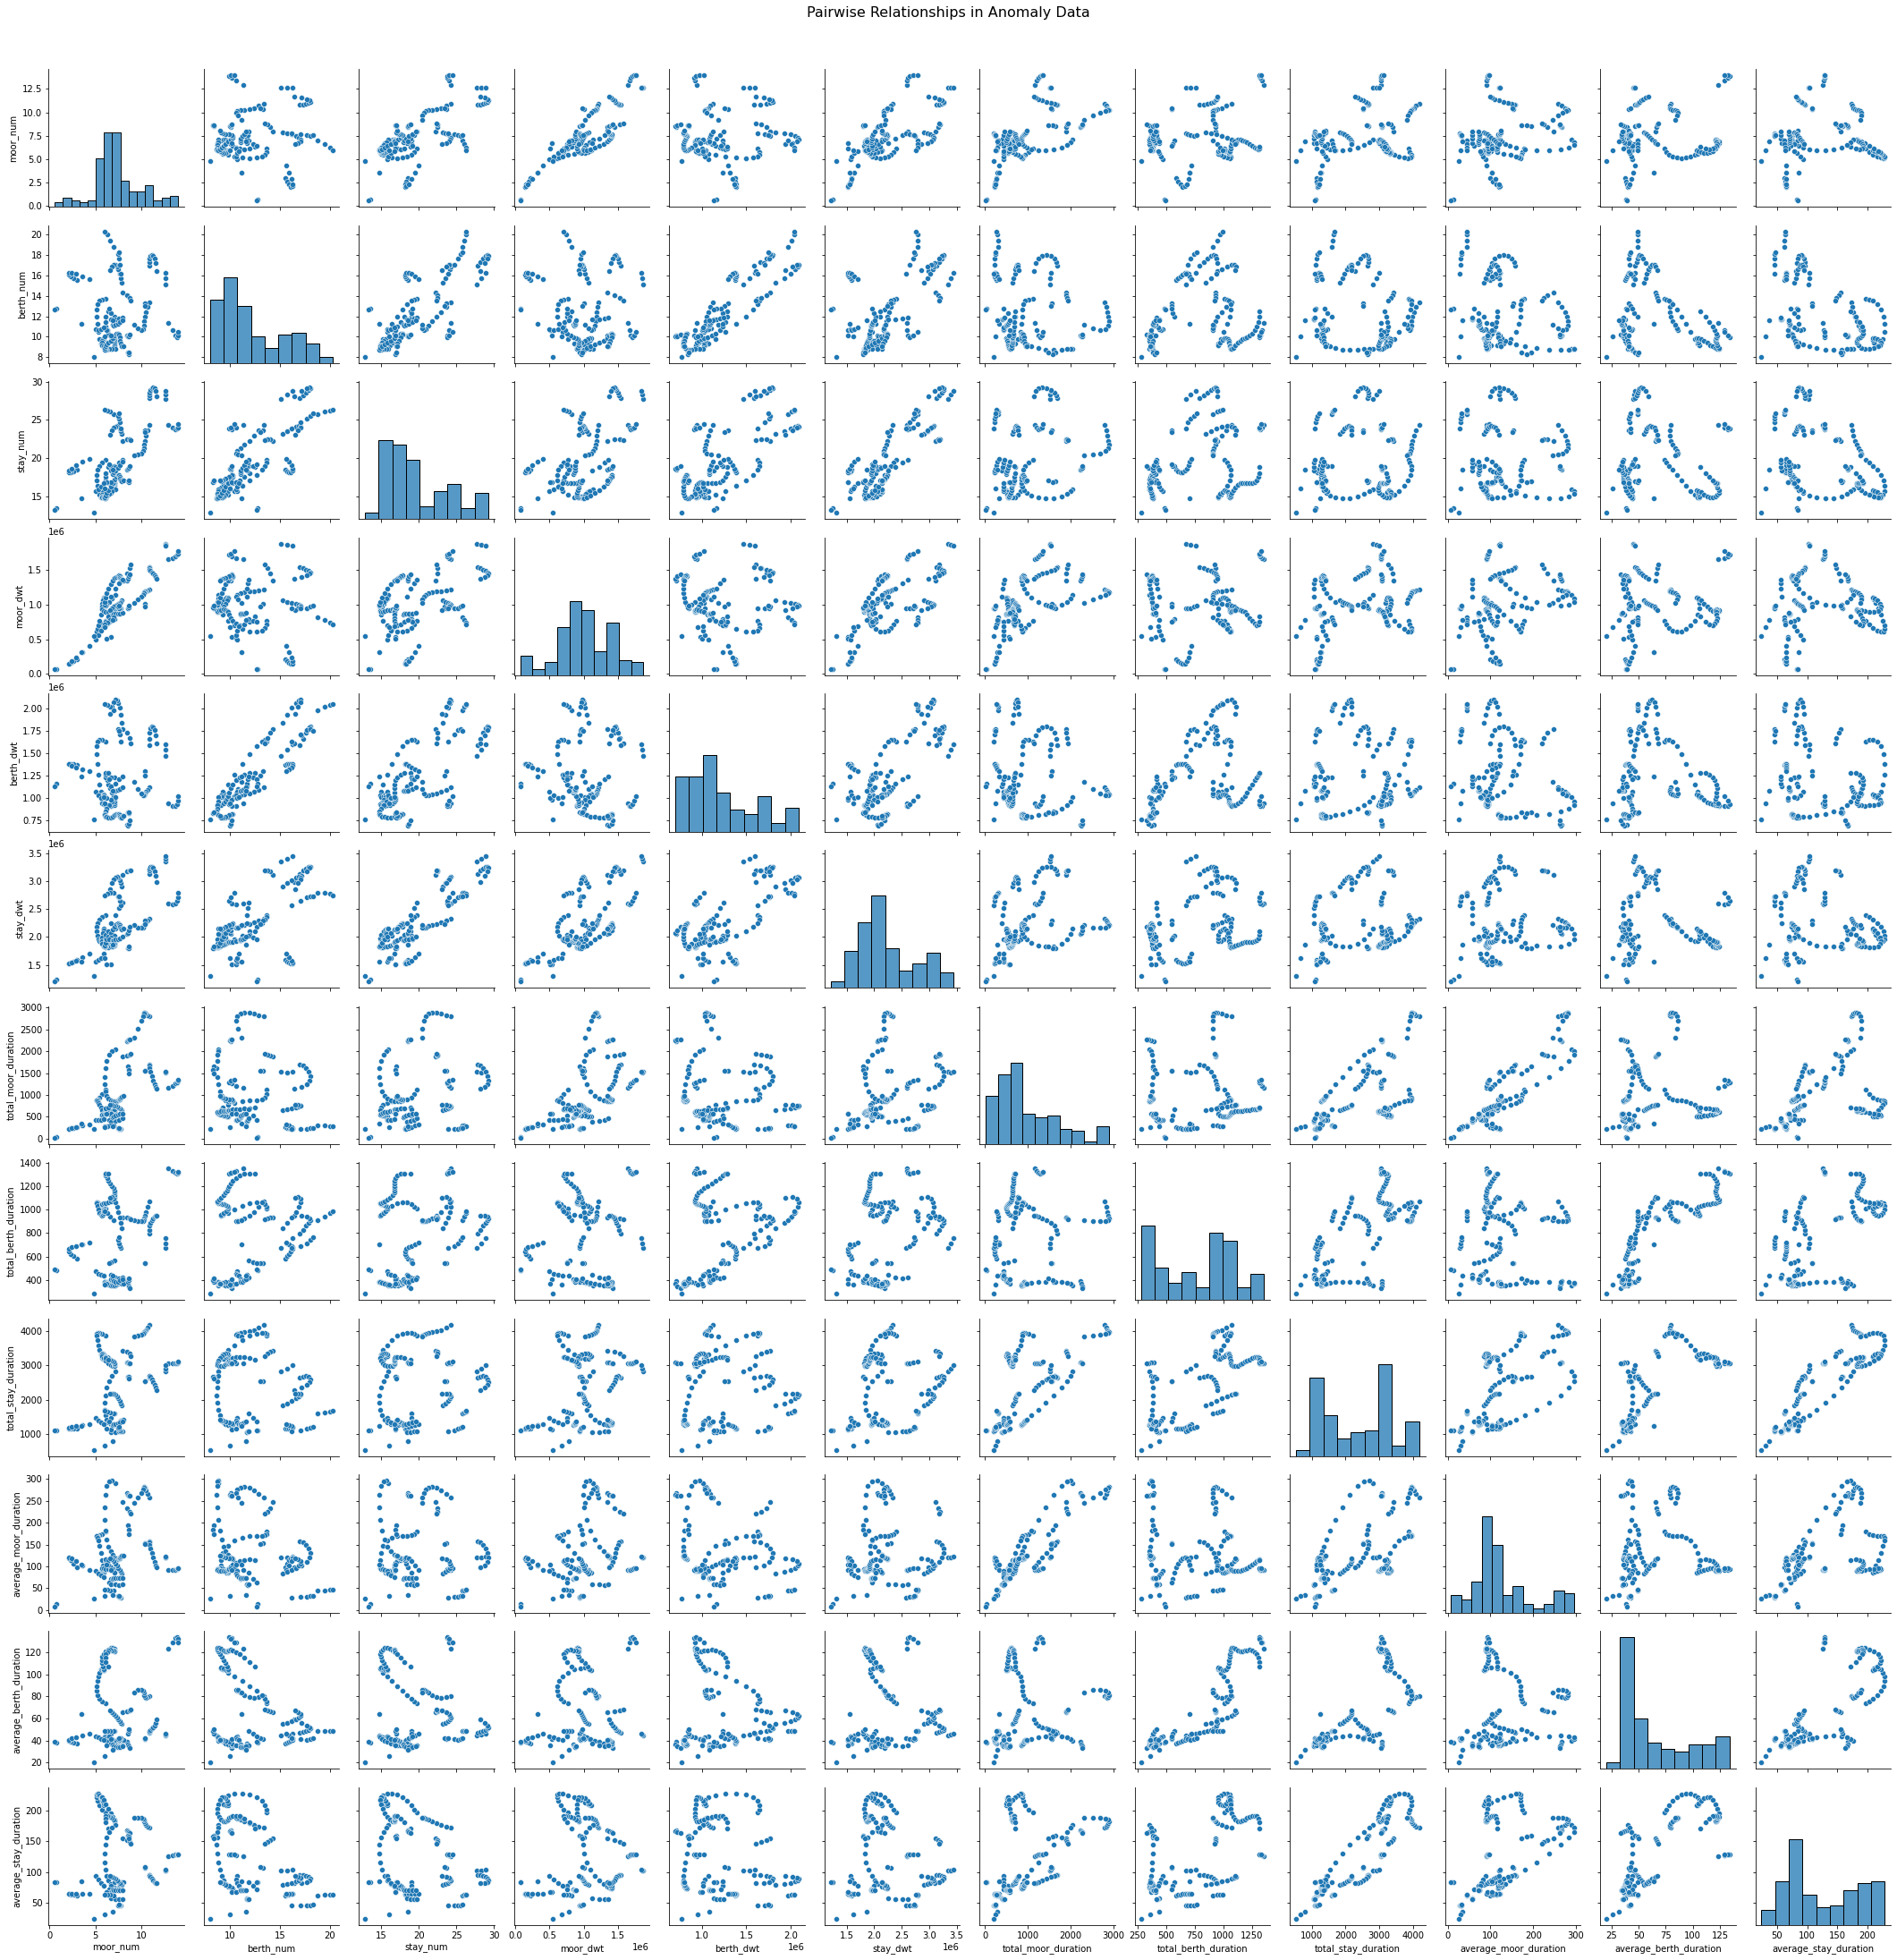

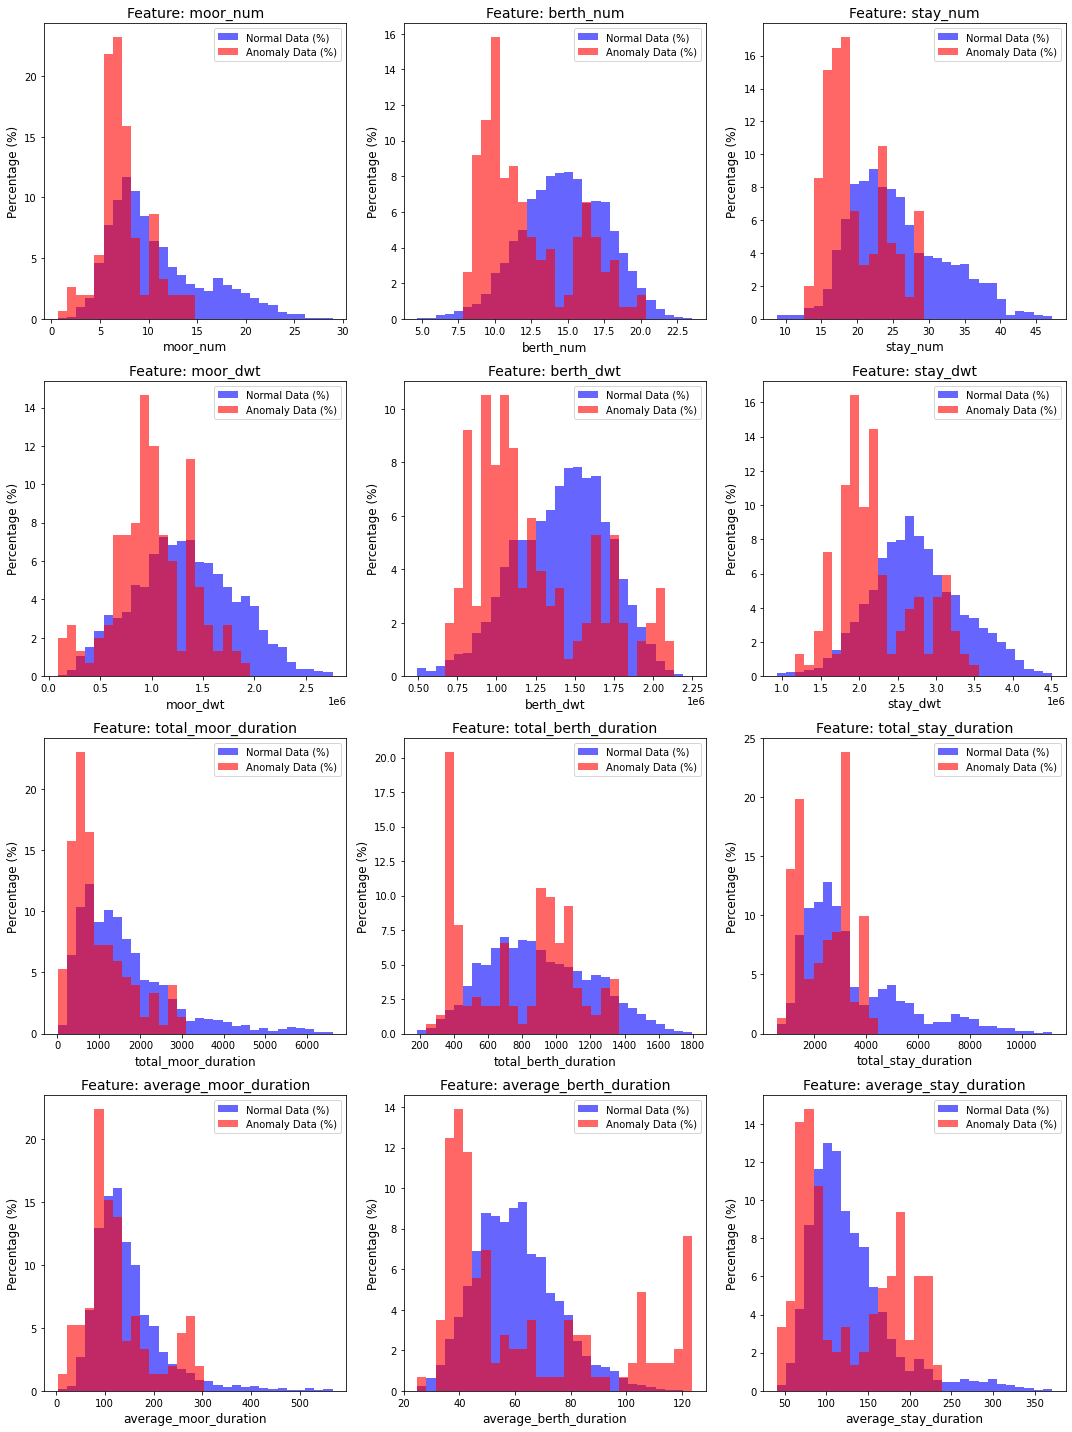

In [ ]:
data = pd.read_csv("data/smoothed_data/smoothed_Boracay_data.csv", parse_dates=["summary_time"], index_col="summary_time")
with open("experiment/Boracay_port/full_dataset_anomaly_timestamps.json", "r") as f:
    anomalies = json.load(f)["anomaly_timestamps"]

anomalies = pd.to_datetime(anomalies)
anomaly_data = data.loc[anomalies]

data_without_time = data.reset_index(drop=True)
anomaly_data_without_time = anomaly_data.reset_index(drop=True)

# Pairwise plot for anomaly data
sns.pairplot(anomaly_data_without_time)
plt.suptitle("Pairwise Relationships in Anomaly Data", y=1.02, fontsize=16)
plt.show()

normal_data = data.drop(anomalies, errors="ignore")
normal_data_without_time = normal_data.reset_index(drop=True)

n_features = anomaly_data_without_time.shape[1]
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(anomaly_data_without_time.columns):
    ax = axes[i]

    normal_counts, bins = np.histogram(normal_data_without_time[col], bins=30)
    anomaly_counts, _ = np.histogram(anomaly_data_without_time[col], bins=bins)
    
    normal_percentages = normal_counts / normal_counts.sum() * 100
    anomaly_percentages = anomaly_counts / anomaly_counts.sum() * 100

    # Plot bar plots for percentages
    bin_centers = (bins[:-1] + bins[1:]) / 2
    ax.bar(bin_centers, normal_percentages, width=(bins[1] - bins[0]), alpha=0.6, label="Normal Data (%)", color="blue")
    ax.bar(bin_centers, anomaly_percentages, width=(bins[1] - bins[0]), alpha=0.6, label="Anomaly Data (%)", color="red")

    ax.set_title(f"Feature: {col}", fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


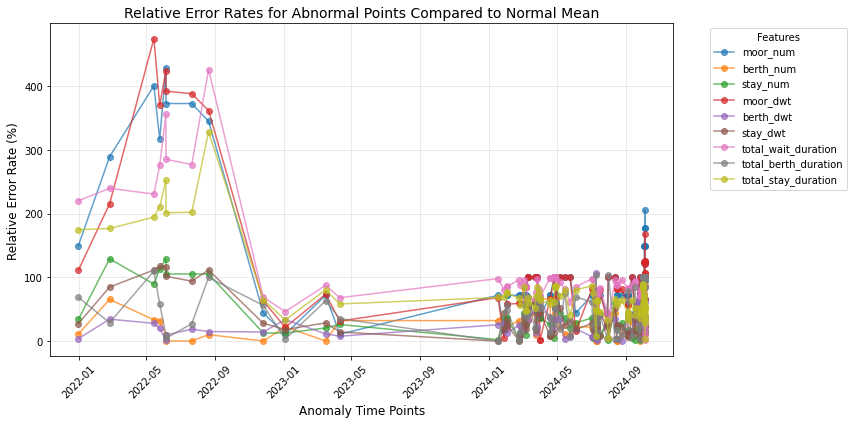

In [4]:
data_path = "data/NewYork_port/NewYork_port_data_2020_2024.csv"
anomalies_path = "experiment/new_york_port/full_dataset_anomaly_timestamps.json"

data = pd.read_csv(data_path, parse_dates=["summary_time"], index_col="summary_time")
with open(anomalies_path, "r") as f:
    anomalies = json.load(f)["anomaly_timestamps"]
anomalies = pd.to_datetime(anomalies)

normal_data = data.drop(anomalies, errors="ignore")
anomaly_data = data.loc[anomalies]

normal_means = normal_data.mean()

relative_errors = ((anomaly_data - normal_means).abs() / normal_means) * 100

plt.figure(figsize=(12, 6))
for feature in relative_errors.columns:
    plt.plot(anomaly_data.index, relative_errors[feature], marker="o", label=feature, alpha=0.7)

plt.title("Relative Error Rates for Abnormal Points Compared to Normal Mean", fontsize=14)
plt.xlabel("Anomaly Time Points", fontsize=12)
plt.ylabel("Relative Error Rate (%)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Features")
plt.xticks(rotation=45, fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Feature Importance Ranking:
average_berth_duration: 0.1408
average_stay_duration: 0.1185
total_stay_duration: 0.0992
total_berth_duration: 0.0858
moor_dwt: 0.0758
average_moor_duration: 0.0751
stay_num: 0.0725
total_moor_duration: 0.0681
berth_num: 0.0676
berth_dwt: 0.0667
stay_dwt: 0.0651
moor_num: 0.0648


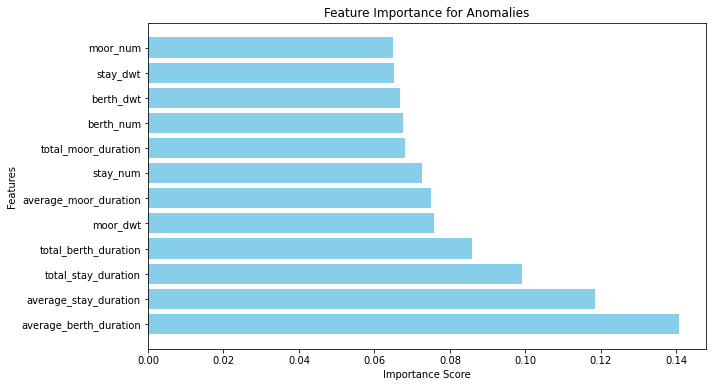

In [10]:
import json
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


with open('experiment/Boracay_port/full_dataset_anomaly_timestamps.json', 'r') as f:
    anomaly_data = json.load(f)
anomaly_timestamps = anomaly_data['anomaly_timestamps']

data = pd.read_csv('data/smoothed_data/smoothed_Boracay_data.csv')
data['is_anomaly'] = data['summary_time'].apply(lambda x: 1 if str(x) in anomaly_timestamps else 0)


features = data[[
    'moor_num', 'berth_num', 'stay_num', 
    'moor_dwt', 'berth_dwt', 'stay_dwt', 
    'total_moor_duration', 'total_berth_duration', 'total_stay_duration',
    'average_moor_duration', 'average_berth_duration', 'average_stay_duration'
]]
target = data['is_anomaly']


rf = RandomForestClassifier(random_state=42)
rf.fit(features, target)

feature_importances = rf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

print("Feature Importance Ranking:")
for idx in sorted_indices:
    print(f"{features.columns[idx]}: {feature_importances[idx]:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(features.columns[sorted_indices], feature_importances[sorted_indices], color='skyblue')
plt.title('Feature Importance for Anomalies')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()
